# Import

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV, ElasticNet
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# XGBoost
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore", category=Warning)

In [6]:
pkl_f = '.../iowa_liquor_clean7.pkl'
df = pd.read_pickle(pkl_f)

### Transformations before downloading iowa_liquor_clean5.pkl

csv_f = '...iowa_liquor_clean2.csv'
df1 = pd.read_csv(csv_f,
        parse_dates=['date'],
        dtype = {'year':np.int16, 'month':np.int8, 'day':np.int8,
        'store_number':np.int16, 'county_number':np.int8, 'item_number':np.int32,
        'pack':np.int16, 'bottle_vol':np.int64, 'bottle_cost':np.float32,
        'state_bottle_retail':np.float32, 'bottles_sold':np.int16, 'sale':np.float32,
        'vol_sold':np.float32, 'bottles_sold':np.int16,
        'category':np.int32, 'store_subnumber':np.int16, 'zip_code':np.int16,
        'vendor_number':np.int16
        })
        

df1.drop(['Unnamed: 0', 'date', 'address', 'store_name', 'item_description', 'store_subname', \
        'county', 'category_name', 'vendor_name'], axis=1, inplace=True)
        
df1.zip_code = df1.zip_code.abs()

df1.city = df1.city.astype('category')
df1.zip_code = df1.zip_code.astype('category')

df1.city = df1.city.cat.add_categories('NaN')
df1.city.fillna('NaN', inplace=True)
df.drop(['zip_code', 'city'], axis=1, inplace=True)

df = df1.query('year == 2016')

df.reset_index(drop=True, inplace=True)

# t-SNE

In [7]:
df1 = df.copy()

# Create a t-SNE model with learning rate 50
m = TSNE(learning_rate=50)

# Fit and transform the t-SNE model on the numeric dataset
tsne_features = m.fit_transform(df1)
tsne_features.shape

(100, 2)

<AxesSubplot:xlabel='fd', ylabel='bottles_sold'>

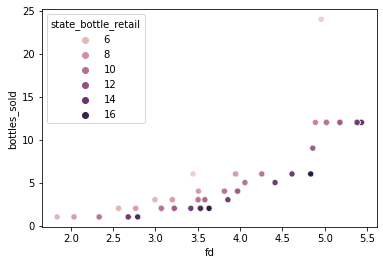

In [8]:
sns.scatterplot(x="fd", y="bottles_sold", hue='state_bottle_retail', data=df1)

# Define Arrays

In [9]:
y = df['fd'].copy().values # fd is the result of applying boxcox on the sale column (fitted data)
X = df.copy().drop(['sale', 'fd'], axis=1)
X_col = X.copy().columns

## Full dataset

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

# Plausible Regressors (without Parameter Tuning)

In [11]:
regression_models = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    ElasticNet(),
    LinearSVR(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    xgb.XGBRegressor()
]

for regression_model in regression_models:
    loop_pipe = make_pipeline(regression_model)
    loop_pipe.fit(X_train, y_train)   
    print(f'{regression_model} \n\
    model score: {loop_pipe.score(X_test, y_test):.4f}')

LinearRegression() 
    model score: 0.9210
Ridge() 
    model score: 0.9206
Lasso() 
    model score: 0.7457
ElasticNet() 
    model score: 0.8199
LinearSVR() 
    model score: -0.2290
RandomForestRegressor() 
    model score: 0.9613
GradientBoostingRegressor() 
    model score: 0.9828
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None) 
    model score: 0.9803


# Let's engage in feature reduction (FD) and then try again.

## FD: Variance

In [12]:
# Normalize the data
normalized_df = df / df.mean()

# Print the variances of the normalized data
print(normalized_df.var())
# Now remove the lowest variance features.

year                   0.000000
month                  0.000000
day                    0.000000
store_number           0.077961
county_number          0.141954
category               0.000716
vendor_number          0.045308
item_number            0.026726
pack                   0.143409
bottle_vol             0.094584
bottle_cost            0.092275
state_bottle_retail    0.090503
bottles_sold           0.899165
sale                   0.923911
fd                     0.089684
vol_sold               0.842055
store_subnumber        7.983308
dtype: float64


In [13]:
df.drop(['year', 'month', 'day'], axis=1, inplace=True)

### year should be dropped. Because we'll reduce the rows to 100 due to computing limitations, we should drop month and year as well.

## FD: Correlations too high

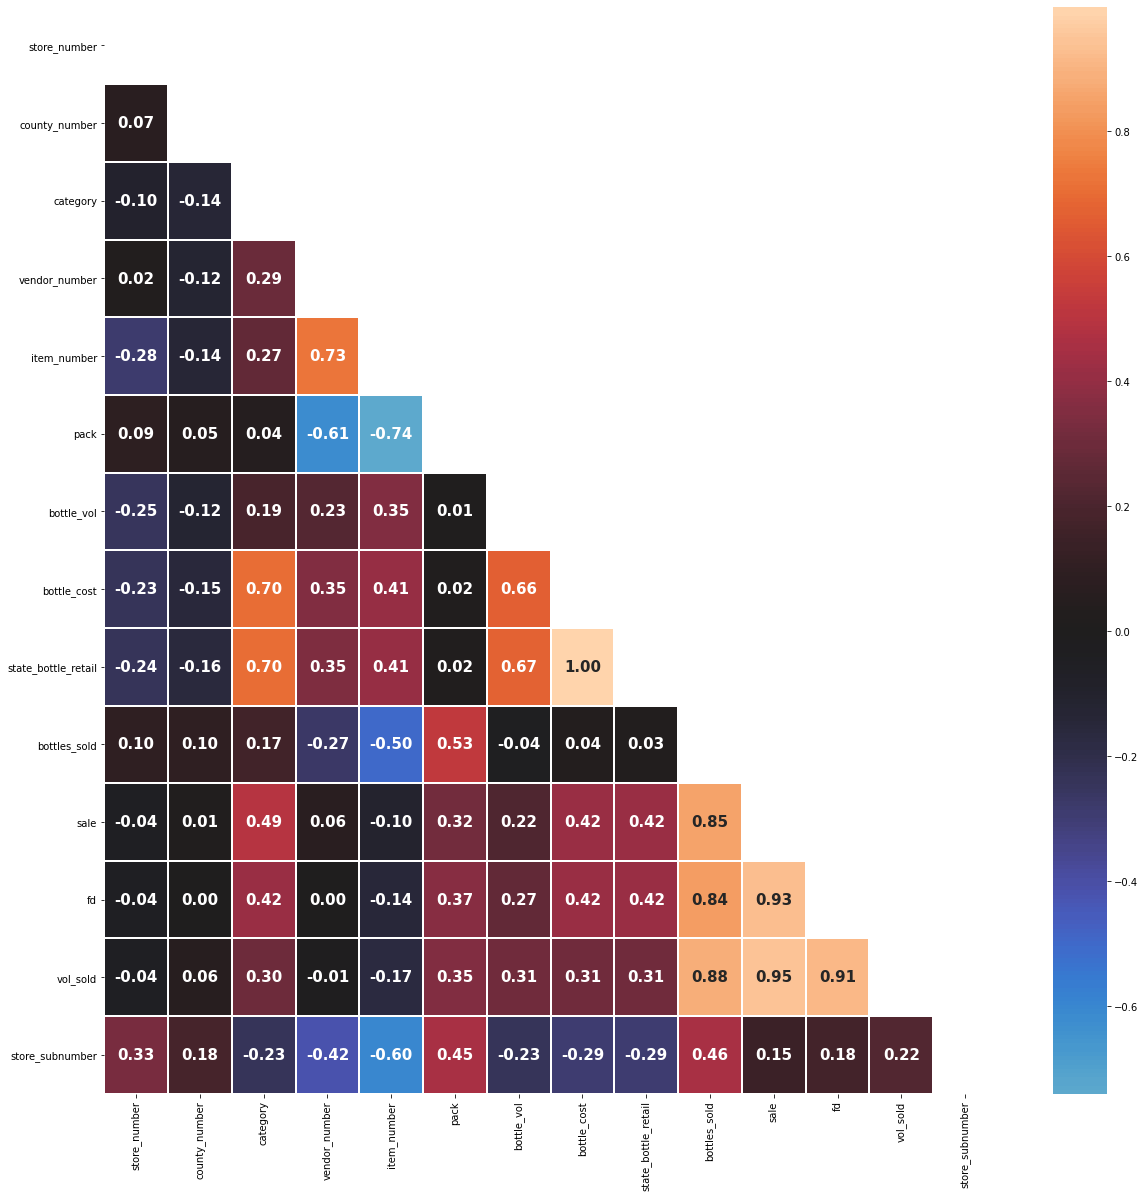

In [14]:
# Create the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# visualize
#sns.color_palette("flare", as_cmap=True)
# cmap = sns.diverging_patterns(h_neg=10, h_pos=240, as_cmap=True)
plt.figure(figsize=[20,20])
sns.heatmap(corr,mask=mask,center=0,linewidths=1,annot=True,fmt=".2f",annot_kws={"fontsize":15, "weight": "bold"})
plt.show()

### The perfect correlation between bottle_cost and state_bottle_retail implies we should drop one. I'll drop state_bottle_retail. The higher correlations, like bottles_sold and vol_sold as well as sale and vol_sold and bottles_sold may be dropped as well (the training data won't have sale, of course).

In [15]:
df.drop('state_bottle_retail', axis=1, inplace=True)

### Redefine Arrays

In [16]:
y = df['fd'].copy().values # fd is the result of applying boxcox on the sale column (fitted data)
X = df.copy().drop(['sale', 'fd'], axis=1)
X_col = X.copy().columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [17]:
from sklearn.linear_model import LassoCV

# Create and fit the LassoCV model on the training set
lcv = LassoCV()
lcv.fit(X_train, y_train)
print(f'Optimal alpha = {lcv.alpha_:.5f}')

# Calculate R squared on the test set
r_squared = lcv.score(X_test, y_test)
print(f'The model explains {r_squared:.1%} of the test set variance')

# Create a mask for coefficients not equal to zero
lcv_mask = lcv.coef_ != 0
print(f'{sum(lcv_mask)} features out of {len(lcv_mask)} selected')

Optimal alpha = 13.23786
The model explains 24.1% of the test set variance
5 features out of 11 selected


In [18]:
# Select 3 features with RFE on a GradientBoostingRegressor
rfe_gb = RFE(estimator=GradientBoostingRegressor(), 
             n_features_to_select=3, step=1, verbose=1)
rfe_gb.fit(X_train, y_train)

# Calculate the R squared on the test set
r_squared = rfe_gb.score(X_test, y_test)
print(f'The model can explain {r_squared:.1%} of the variance in the test set')

# Assign the support array to gb_mask
gb_mask = rfe_gb.support_

Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
The model can explain 99.3% of the variance in the test set


In [19]:
# Select 3 features with RFE on a RandomForestRegressor, drop 1 feature on each step
rfe_rf = RFE(estimator=RandomForestRegressor(), 
             n_features_to_select=3, step=1, verbose=1)
rfe_rf.fit(X_train, y_train)

# Calculate the R squared on the test set
r_squared = rfe_rf.score(X_test, y_test)
print(f'The model can explain {r_squared:.1%} of the variance in the test set')

# Assign the support array to gb_mask
rf_mask = rfe_rf.support_

Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
The model can explain 99.2% of the variance in the test set


In [20]:
# Sum the votes of the three models. True values are votes to keep a feature.
votes = np.sum([lcv_mask, rf_mask, gb_mask], axis=0)

# Create a mask for features selected by all 3 models
meta_mask = votes >= 2

# Apply the dimensionality reduction on X
X_reduced = X.loc[:, meta_mask]

lm = LinearRegression()
scaler = StandardScaler()

# Plug the reduced dataset into a linear regression pipeline
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.3, random_state=0)
lm.fit(scaler.fit_transform(X_train), y_train)
r_squared = lm.score(scaler.transform(X_test), y_test)
print(f'The model can explain {r_squared:.1%} of the variance in the test set using {len(lm.coef_)} features. \n\n\
Features to keep: \n\t{X_reduced.columns}')

The model can explain 86.6% of the variance in the test set using 3 features. 

Features to keep: 
	Index(['bottle_cost', 'bottles_sold', 'vol_sold'], dtype='object')


In [21]:
lcv = pd.Series(data=lcv_mask, index=X.columns)
gb = pd.Series(data=gb_mask, index=X.columns)
rfe = pd.Series(data=rf_mask, index=X.columns)
f = pd.concat([lcv, gb, rfe], axis=1)
f.aggregate(func=np.sum, axis=1), f

(store_number       1
 county_number      0
 category           1
 vendor_number      0
 item_number        1
 pack               0
 bottle_vol         1
 bottle_cost        2
 bottles_sold       2
 vol_sold           2
 store_subnumber    1
 dtype: int64,
                      0      1      2
 store_number      True  False  False
 county_number    False  False  False
 category          True  False  False
 vendor_number    False  False  False
 item_number       True  False  False
 pack             False  False  False
 bottle_vol        True  False  False
 bottle_cost      False   True   True
 bottles_sold     False   True   True
 vol_sold         False   True   True
 store_subnumber   True  False  False)

### The two most accurate models agree on the three features to keep.

In [22]:
X_reduced

,bottle_cost,bottles_sold,vol_sold
0,6.50,4,3.00
1,10.00,2,1.50
2,6.50,5,3.75
3,6.50,6,4.50
4,6.50,12,9.00
...,...,...,...
95,9.00,12,9.00
96,3.82,3,2.25
97,3.82,1,0.75
98,3.82,3,2.25


## The most severe feature reduction leaves us with three features. Let's start from the beginning and cutout features as we go, ending with feeding only these three features.

# Feature Selection Results and repeat

In [23]:
df.drop(['vendor_number', 'store_subnumber'], axis=1, inplace=True)

In [24]:
y = df['fd'].copy().values # fd is the result of applying boxcox on the sale column (fitted data)
X = df.copy().drop(['sale', 'fd'], axis=1)
X_col = X.copy().columns

In [25]:
X.head()

,store_number,county_number,category,item_number,pack,bottle_vol,bottle_cost,bottles_sold,vol_sold
0,5022,77,1031200,41989,12,750,6.5,4,3.00
1,2460,100,1062100,42166,12,750,10.0,2,1.50
2,2590,57,1031200,41989,12,750,6.5,5,3.75
3,2648,77,1031200,41989,12,750,6.5,6,4.50
4,4312,78,1031200,41989,12,750,6.5,12,9.00


In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [27]:
regression_models = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    ElasticNet(),
    LinearSVR(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    xgb.XGBRegressor()
]

for regression_model in regression_models:
    loop_pipe = make_pipeline(regression_model)
    loop_pipe.fit(X_train, y_train)   
    print(f'{regression_model} \n\
    model score: {loop_pipe.score(X_test, y_test):.4f}')

LinearRegression() 
    model score: 0.9187
Ridge() 
    model score: 0.9189
Lasso() 
    model score: 0.7941
ElasticNet() 
    model score: 0.8474
LinearSVR() 
    model score: -2.2796
RandomForestRegressor() 
    model score: 0.9703
GradientBoostingRegressor() 
    model score: 0.9891
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None) 
    model score: 0.9883


## These scores are slightly better after feature selection.

# Feature Selection Again and Repeat

In [28]:
df.drop(['category', 'item_number', 'pack', 'bottle_cost', 'vol_sold'], axis=1, inplace=True)

In [29]:
y = df['fd'].copy().values # fd is the result of applying boxcox on the sale column (fitted data)
X = df.copy().drop(['sale', 'fd'], axis=1)
X_col = X.copy().columns

In [30]:
X.head()

,store_number,county_number,bottle_vol,bottles_sold
0,5022,77,750,4
1,2460,100,750,2
2,2590,57,750,5
3,2648,77,750,6
4,4312,78,750,12


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [32]:
regression_models = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    ElasticNet(),
    LinearSVR(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    xgb.XGBRegressor()
]

for regression_model in regression_models:
    loop_pipe = make_pipeline(regression_model)
    loop_pipe.fit(X_train, y_train)   
    print(f'{regression_model} \n\
    model score: {loop_pipe.score(X_test, y_test):.4f}')

LinearRegression() 
    model score: 0.8731
Ridge() 
    model score: 0.8730
Lasso() 
    model score: 0.7845
ElasticNet() 
    model score: 0.8289
LinearSVR() 
    model score: -0.5168
RandomForestRegressor() 
    model score: 0.9337
GradientBoostingRegressor() 
    model score: 0.9369
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None) 
    model score: 0.9395


## Even better results. Let's keep what we have and go onto to the best performing models with hyperparameter tuning.
### Because the models are decision trees, there is no need to scale the numeric data.

# Random Forest Regressor

In [33]:
pipeline = make_pipeline(RandomForestRegressor())

# Parameters
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'randomforestregressor__n_estimators': n_estimators,
               'randomforestregressor__max_features': max_features,
               'randomforestregressor__max_depth': max_depth,
               'randomforestregressor__min_samples_split': min_samples_split,
               'randomforestregressor__min_samples_leaf': min_samples_leaf,
               'randomforestregressor__bootstrap': bootstrap}
print(random_grid)

cv_rf = RandomizedSearchCV(pipeline, random_grid, cv=3)

{'randomforestregressor__n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'randomforestregressor__max_features': ['auto', 'sqrt'], 'randomforestregressor__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'randomforestregressor__min_samples_split': [2, 5, 10], 'randomforestregressor__min_samples_leaf': [1, 2, 4], 'randomforestregressor__bootstrap': [True, False]}


In [34]:
cv_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('randomforestregressor',
                                              RandomForestRegressor())]),
                   param_distributions={'randomforestregressor__bootstrap': [True,
                                                                             False],
                                        'randomforestregressor__max_depth': [10,
                                                                             20,
                                                                             30,
                                                                             40,
                                                                             50,
                                                                             60,
                                                                             70,
                                                                             80,
              

In [35]:
print(f'Best parameters: \n{cv_rf.best_params_} \n\n\
Training accuracy score from tuned model: {cv_rf.best_score_*100:.2f}%') # 90.81

Best parameters: 
{'randomforestregressor__n_estimators': 2000, 'randomforestregressor__min_samples_split': 5, 'randomforestregressor__min_samples_leaf': 2, 'randomforestregressor__max_features': 'auto', 'randomforestregressor__max_depth': 70, 'randomforestregressor__bootstrap': True} 

Training accuracy score from tuned model: 93.19%


In [36]:
rf_y_pred = cv_rf.predict(X_test)

mse = mean_squared_error(y_test, rf_y_pred)
print(f'MSE: {mse:.2f} \n\
RMSE: {mse ** (1/2):.2f} \n\
Score: {cv_rf.score(X_test, y_test):.2f} \n\
Explained Variance Score: {explained_variance_score(y_test, rf_y_pred):.2f}') # .09, .05, .91, -

MSE: 0.07 
RMSE: 0.26 
Score: 0.94 
Explained Variance Score: 0.94


#### Commented out in the above cell is the score before any feature selection. 
 - MSE: .09
 - RMSE: .05
 - Score: .91

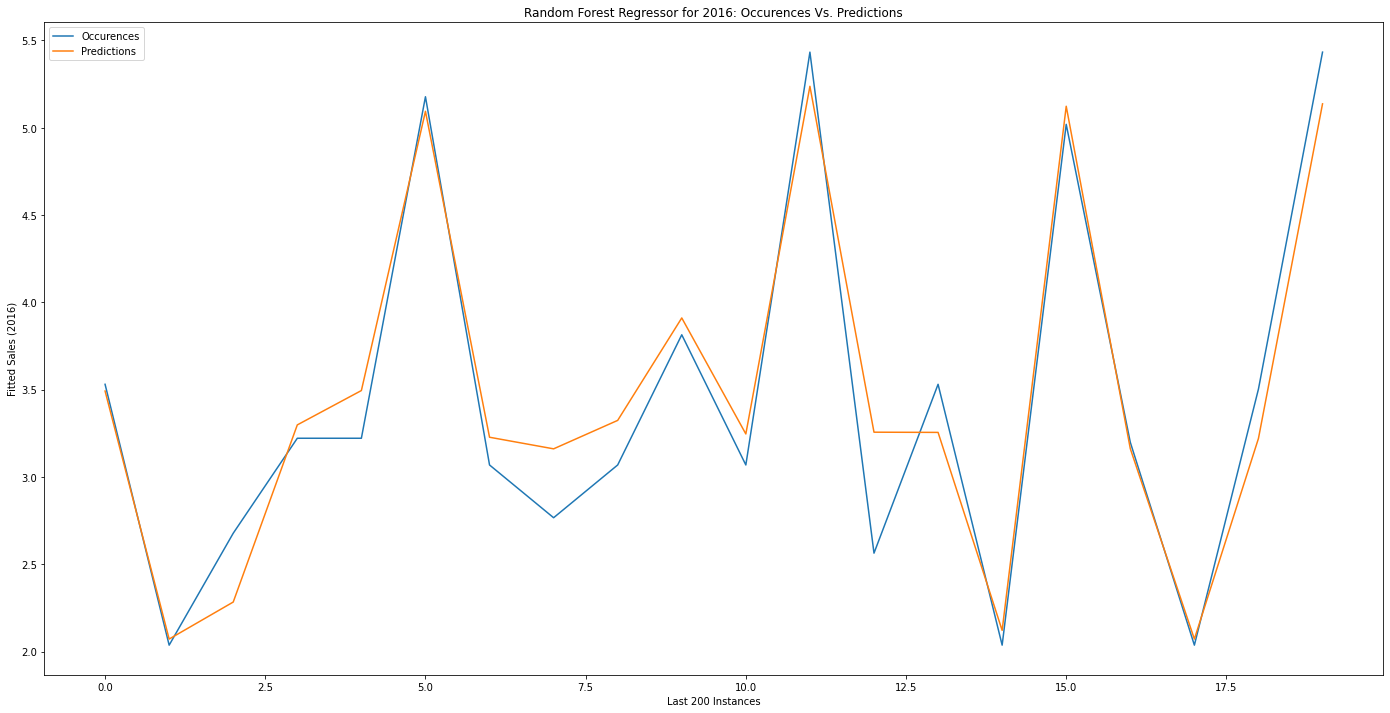

In [37]:
_ = plt.figure(figsize=(24, 12))
_ = x_ax = range(len(y_test[-200:]))
_ = plt.plot(x_ax, y_test[-200:], label="Occurences")
_ = plt.plot(x_ax, rf_y_pred[-200:], label="Predictions")
_ = plt.title('Random Forest Regressor for 2016: Occurences Vs. Predictions')
_ = plt.xlabel('Last 200 Instances')
_ = plt.ylabel('Fitted Sales (2016)')
_ = plt.legend()
_ = plt.show()

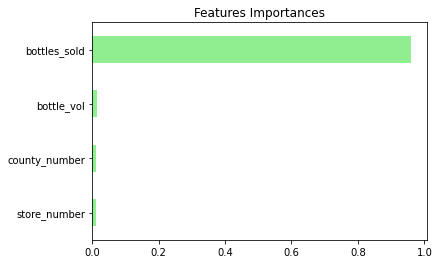

In [38]:
fi = cv_rf.best_estimator_.named_steps["randomforestregressor"].feature_importances_

# Create a pd.Series of features importances
importances = pd.Series(data = fi,
                        index = X_train.columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()

#### According to our Random Forest models, I could drop all but the top two features. Let's try it.

# Gradient Boosting Regressor

In [39]:
pipeline = make_pipeline(GradientBoostingRegressor())

# grid search parameters
params = {'gradientboostingregressor__learning_rate': [.1, .3, .5, .7, .9],
          'gradientboostingregressor__n_estimators': [50, 80, 100, 120, 140, 180, 250],
          'gradientboostingregressor__subsample': [.6, .8, 1, 1.2, 1.4, 1.9],
          'gradientboostingregressor__min_samples_split': [1, 2, 3, 4, 6]}

cv_gb = RandomizedSearchCV(pipeline, params, cv=3)

In [40]:
cv_gb.fit(X_train, y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('gradientboostingregressor',
                                              GradientBoostingRegressor())]),
                   param_distributions={'gradientboostingregressor__learning_rate': [0.1,
                                                                                     0.3,
                                                                                     0.5,
                                                                                     0.7,
                                                                                     0.9],
                                        'gradientboostingregressor__min_samples_split': [1,
                                                                                         2,
                                                                                         3,
                                                                                         4,
   

In [41]:
print(f'Best parameters: {cv_gb.best_params_} \n\n\
Training accuracy score from tuned model: {cv_gb.best_score_*100:.2f}%')

Best parameters: {'gradientboostingregressor__subsample': 0.8, 'gradientboostingregressor__n_estimators': 120, 'gradientboostingregressor__min_samples_split': 6, 'gradientboostingregressor__learning_rate': 0.1} 

Training accuracy score from tuned model: 92.06%


In [42]:
gb_y_pred = cv_gb.predict(X_test)

mse = mean_squared_error(y_test, gb_y_pred)
print(f'MSE: {mse:.3f}% \n\
RMSE: {(mse*(1/2.0)):.3f} \n\
Score: {cv_gb.score(X_test, y_test):.3f} \n\
Explained Variance Score: {explained_variance_score(y_test, gb_y_pred):.2f}') # .05, .023, .95759

MSE: 0.060% 
RMSE: 0.030 
Score: 0.945 
Explained Variance Score: 0.95


#### Without feature selection, the scores were:
- MSE: .05
- RMSE: .023
- Score: .95759

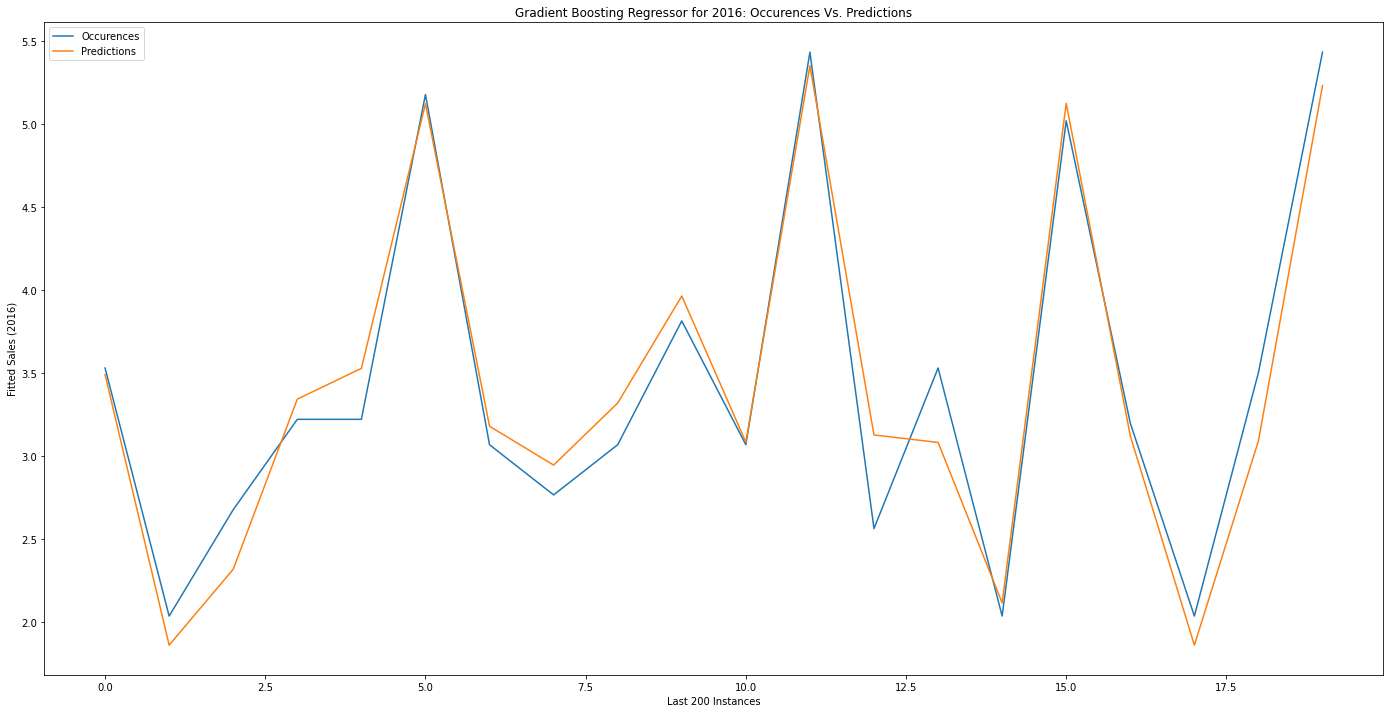

In [43]:
_ = plt.figure(figsize=(24, 12))
_ = x_ax = range(len(y_test[-200:]))
_ = plt.plot(x_ax, y_test[-200:], label="Occurences")
_ = plt.plot(x_ax, gb_y_pred[-200:], label="Predictions")
_ = plt.title('Gradient Boosting Regressor for 2016: Occurences Vs. Predictions')
_ = plt.xlabel('Last 200 Instances')
_ = plt.ylabel('Fitted Sales (2016)')
_ = plt.legend()
_ = plt.show()

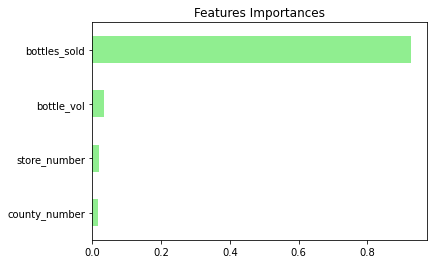

In [44]:
fi = cv_gb.best_estimator_.named_steps["gradientboostingregressor"].feature_importances_

# Create a pd.Series of features importances
importances = pd.Series(data = fi,
                        index = X_train.columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()

#### Gradient Boosting Regressor agrees with RFR: we could drop all but two features and have good models.

# Stochastic Regression

In [45]:
sgbr = GradientBoostingRegressor(max_depth=4, 
            subsample=.9,
            max_features=.75,
            n_estimators=200,                                
            random_state=2)

# Fit sgbr to the training set
sgbr.fit(X_train, y_train)

# Predict test set labels
sgbr_y_pred = sgbr.predict(X_test)

In [46]:
sgbr_y_pred = sgbr.predict(X_test)

mse = mean_squared_error(y_test, sgbr_y_pred)
print(f'MSE: {mse:.3f}% \n\
RMSE: {(mse*(1/2.0)):.3f} \n\
Score: {sgbr.score(X_test, y_test):.3f} \n\
Explained Variance Score: {explained_variance_score(y_test, sgbr_y_pred):.2f}') # .RMSE: .135

MSE: 0.069% 
RMSE: 0.034 
Score: 0.937 
Explained Variance Score: 0.94


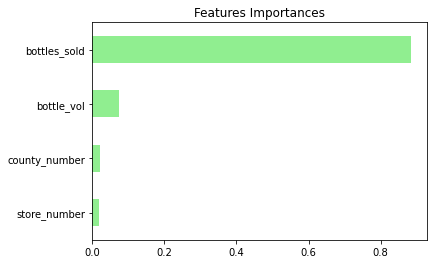

In [47]:
fi_ = sgbr.feature_importances_

# Create a pd.Series of features importances
importances = pd.Series(data = fi_,
                        index = X_train.columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()

#### Similar results, but with slight (instead of no) importance on bottle_vol than those before it.

# XGBoost Regressor

In [48]:
parameters = {'xgbregressor__nthread':[4], #when use hyperthread, xgboost may become slower
              'xgbregressor__objective':['reg:linear'],
              'xgbregressor__learning_rate': [.03, 0.05, .07], #so called `eta` value
              'xgbregressor__max_depth': [5, 6, 7],
              'xgbregressor__min_child_weight': [4],
              'xgbregressor__silent': [1],
              'xgbregressor__subsample': [0.7],
              'xgbregressor__colsample_bytree': [0.7],
              'xgbregressor__n_estimators': [500]}

#incorporating the random forest estimator
pipeline = make_pipeline(xgb.XGBRegressor())

cv_xgb = RandomizedSearchCV(pipeline, parameters, cv=3)

In [49]:
cv_xgb.fit(X_train, y_train)

[16:37:45] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:37:45] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:45] WARNING: /Users/travis/build/dmlc/xgboost/src/objective/regression_obj.cu:174: reg:linear is now deprecated in favor of reg:squarederror.
[16:37:45] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bind

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('xgbregressor',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           colsample_bylevel=None,
                                                           colsample_bynode=None,
                                                           colsample_bytree=None,
                                                           gamma=None,
                                                           gpu_id=None,
                                                           importance_type='gain',
                                                           interaction_constraints=None,
                                                           learning_rate=None,
                                                           max_delta_step=None,
                                           

In [50]:
print(f'Best parameters: {cv_xgb.best_params_} \n\n\
Training accuracy score from tuned model: {cv_xgb.best_score_*100:.2f}%') #Score: 95.36

Best parameters: {'xgbregressor__subsample': 0.7, 'xgbregressor__silent': 1, 'xgbregressor__objective': 'reg:linear', 'xgbregressor__nthread': 4, 'xgbregressor__n_estimators': 500, 'xgbregressor__min_child_weight': 4, 'xgbregressor__max_depth': 5, 'xgbregressor__learning_rate': 0.03, 'xgbregressor__colsample_bytree': 0.7} 

Training accuracy score from tuned model: 90.63%


In [51]:
xgb_y_pred = cv_xgb.predict(X_test)

mse = mean_squared_error(y_test, xgb_y_pred)
print(f'MSE: {mse:.3f}% \n\
RMSE: {(mse*(1/2.0)):.3f} \n\
Score: {cv_xgb.score(X_test, y_test):.3f} \n\
Explained Variance Score: {explained_variance_score(y_test, xgb_y_pred):.2f}') # .05, .023, .959

MSE: 0.093% 
RMSE: 0.046 
Score: 0.915 
Explained Variance Score: 0.92


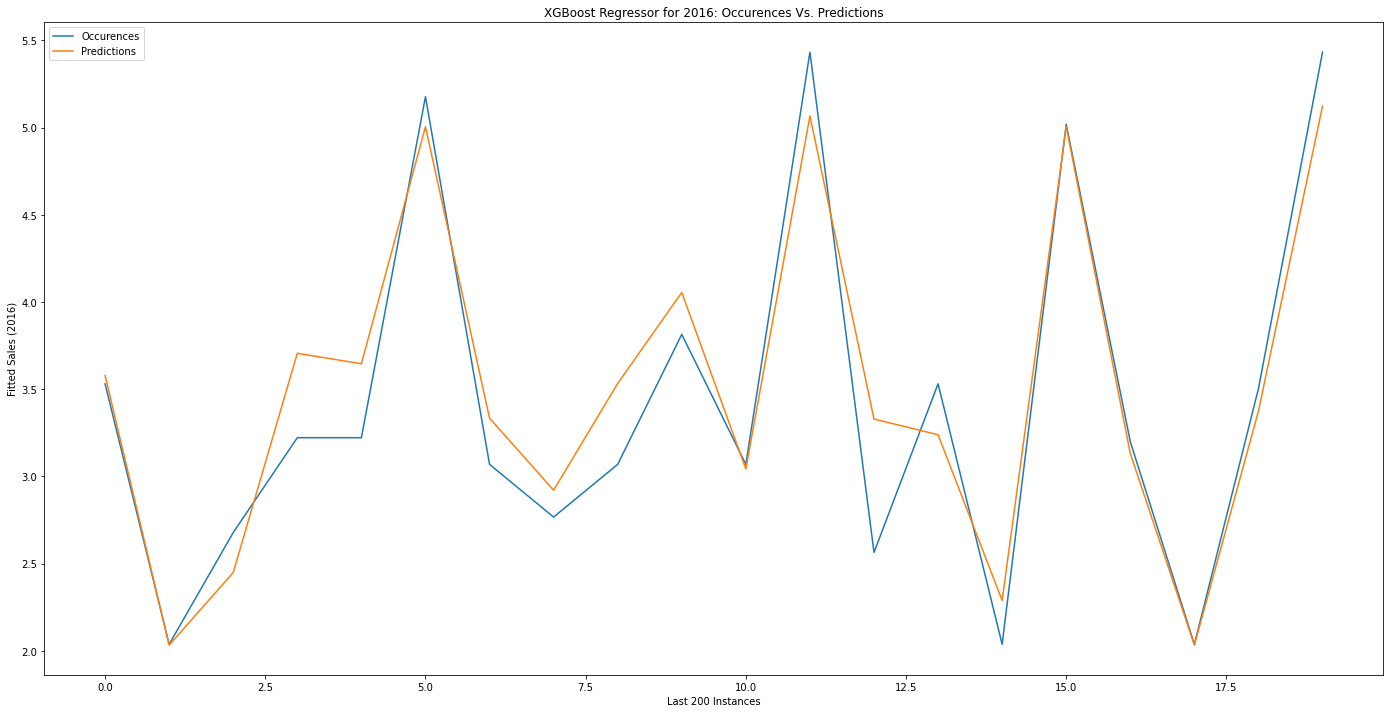

In [52]:
_ = plt.figure(figsize=(24, 12))
_ = x_ax = range(len(y_test[-200:]))
_ = plt.plot(x_ax, y_test[-200:], label="Occurences")
_ = plt.plot(x_ax, xgb_y_pred[-200:], label="Predictions")
_ = plt.title('XGBoost Regressor for 2016: Occurences Vs. Predictions')
_ = plt.xlabel('Last 200 Instances')
_ = plt.ylabel('Fitted Sales (2016)')
_ = plt.legend()
_ = plt.show()

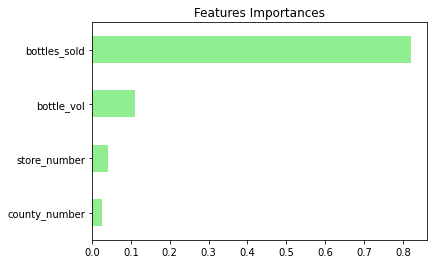

In [53]:
fi = cv_xgb.best_estimator_.named_steps["xgbregressor"].feature_importances_

# Create a pd.Series of features importances
importances = pd.Series(data = fi,
                        index = X_train.columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()

# Repeat Models with Three Features

In [54]:
X = X_reduced.copy()
X_col = X_reduced.columns

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [56]:
regression_models = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    ElasticNet(),
    LinearSVR(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    xgb.XGBRegressor()
]

for regression_model in regression_models:
    loop_pipe = make_pipeline(regression_model)
    loop_pipe.fit(X_train, y_train)   
    print(f'{regression_model} \n\
    model score: {loop_pipe.score(X_test, y_test):.4f}')

LinearRegression() 
    model score: 0.9311
Ridge() 
    model score: 0.9310
Lasso() 
    model score: 0.7601
ElasticNet() 
    model score: 0.8353
LinearSVR() 
    model score: 0.9293
RandomForestRegressor() 
    model score: 0.9910
GradientBoostingRegressor() 
    model score: 0.9930
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None) 
    model score: 0.9973


# XGB Regressor

In [57]:
parameters = {'xgbregressor__nthread':[4], #when use hyperthread, xgboost may become slower
              'xgbregressor__objective':['reg:squarederror'],
              'xgbregressor__learning_rate': [.03, 0.05, .07], #so called `eta` value
              'xgbregressor__max_depth': [5, 6, 7],
              'xgbregressor__min_child_weight': [4],
              'xgbregressor__silent': [1],
              'xgbregressor__subsample': [0.7],
              'xgbregressor__colsample_bytree': [0.7],
              'xgbregressor__n_estimators': [500]}

#incorporating the random forest estimator
pipeline = make_pipeline(xgb.XGBRegressor(silent=True))

cv_xgb = RandomizedSearchCV(pipeline, parameters, cv=3)

In [58]:
cv_xgb.fit(X_train, y_train)

[16:37:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:37:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:37:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('xgbregressor',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           colsample_bylevel=None,
                                                           colsample_bynode=None,
                                                           colsample_bytree=None,
                                                           gamma=None,
                                                           gpu_id=None,
                                                           importance_type='gain',
                                                           interaction_constraints=None,
                                                           learning_rate=None,
                                                           max_delta_step=None,
                                           

In [59]:
print(f'Best parameters: {cv_xgb.best_params_} \n\n\
Training accuracy score from tuned model: {cv_xgb.best_score_*100:.2f}%') #Score: 95.36

Best parameters: {'xgbregressor__subsample': 0.7, 'xgbregressor__silent': 1, 'xgbregressor__objective': 'reg:squarederror', 'xgbregressor__nthread': 4, 'xgbregressor__n_estimators': 500, 'xgbregressor__min_child_weight': 4, 'xgbregressor__max_depth': 5, 'xgbregressor__learning_rate': 0.03, 'xgbregressor__colsample_bytree': 0.7} 

Training accuracy score from tuned model: 99.13%


In [60]:
xgb_y_pred = cv_xgb.predict(X_test)

mse = mean_squared_error(y_test, xgb_y_pred)
print(f'MSE: {mse:.3f}% \n\
RMSE: {(mse*(1/2.0)):.3f} \n\
Score: {cv_xgb.score(X_test, y_test):.3f} \n\
Explained Variance Score: {explained_variance_score(y_test, xgb_y_pred):.2f}') # .05, .023, .959

MSE: 0.005% 
RMSE: 0.003 
Score: 0.995 
Explained Variance Score: 1.00


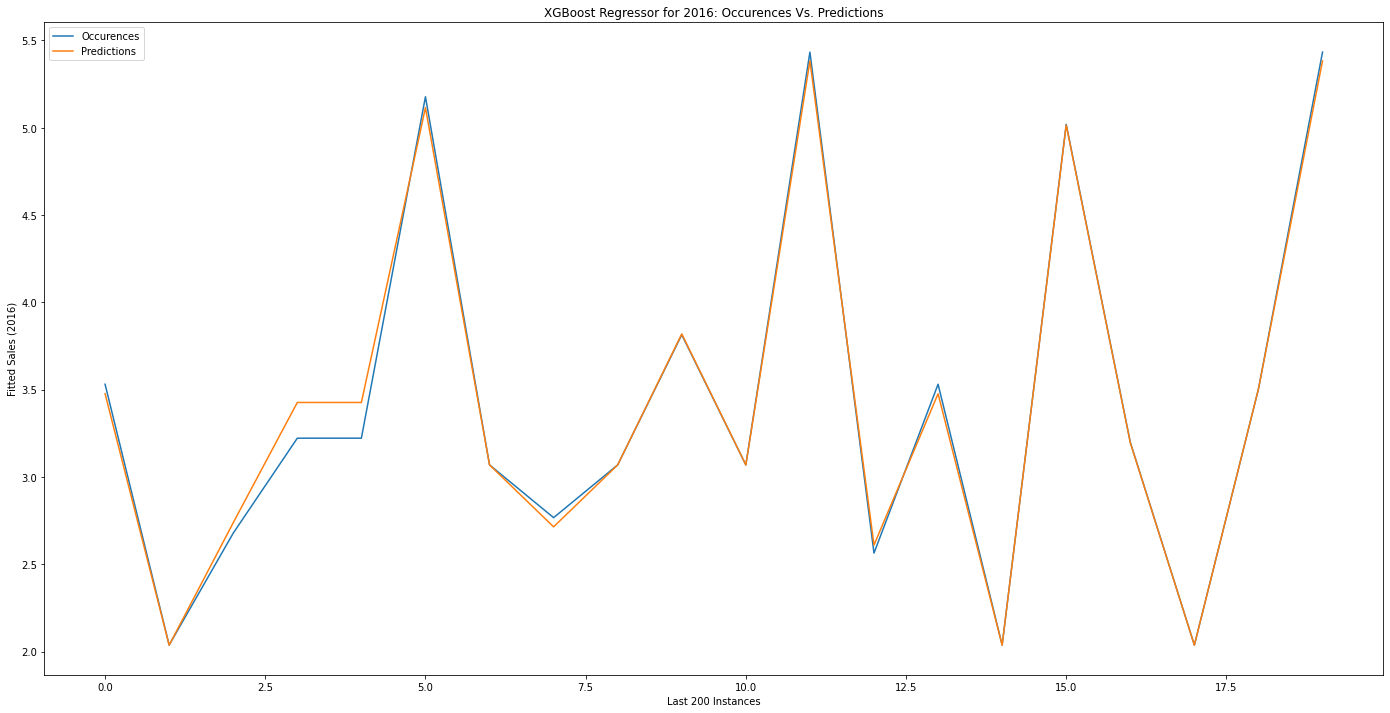

In [61]:
_ = plt.figure(figsize=(24, 12))
_ = x_ax = range(len(y_test[-200:]))
_ = plt.plot(x_ax, y_test[-200:], label="Occurences")
_ = plt.plot(x_ax, xgb_y_pred[-200:], label="Predictions")
_ = plt.title('XGBoost Regressor for 2016: Occurences Vs. Predictions')
_ = plt.xlabel('Last 200 Instances')
_ = plt.ylabel('Fitted Sales (2016)')
_ = plt.legend()
_ = plt.show()

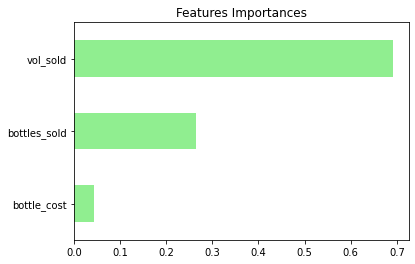

In [64]:
fi = cv_xgb.best_estimator_.named_steps["xgbregressor"].feature_importances_

# Create a pd.Series of features importances
importances = pd.Series(data = fi,
                        index = X_train.columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()

### With features reduced to three, this XGB Regressor model scores the highest. 

## Let's see if the score is higher without the weakest feature: bottle_cost.

In [65]:
X2 = X_reduced.drop('bottle_cost', axis=1, inplace=True)
X2f = X_reduced
X2f_col = X2f.columns

X_train, X_test, y_train, y_test = train_test_split(X2f, y, test_size=.2, random_state=42)

### XGB Regressor

In [66]:
parameters = {'xgbregressor__nthread':[4], #when use hyperthread, xgboost may become slower
              'xgbregressor__objective':['reg:squarederror'],
              'xgbregressor__learning_rate': [.03, 0.05, .07], #so called `eta` value
              'xgbregressor__max_depth': [5, 6, 7],
              'xgbregressor__min_child_weight': [4],
              'xgbregressor__silent': [1],
              'xgbregressor__subsample': [0.7],
              'xgbregressor__colsample_bytree': [0.7],
              'xgbregressor__n_estimators': [500]}

#incorporating the random forest estimator
pipeline = make_pipeline(xgb.XGBRegressor(silent=True))

cv_xgb = RandomizedSearchCV(pipeline, parameters, cv=3)

In [67]:
cv_xgb.fit(X_train, y_train)

[16:37:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:37:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:37:51] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:516: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through t

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('xgbregressor',
                                              XGBRegressor(base_score=None,
                                                           booster=None,
                                                           colsample_bylevel=None,
                                                           colsample_bynode=None,
                                                           colsample_bytree=None,
                                                           gamma=None,
                                                           gpu_id=None,
                                                           importance_type='gain',
                                                           interaction_constraints=None,
                                                           learning_rate=None,
                                                           max_delta_step=None,
                                           

In [68]:
print(f'Best parameters: {cv_xgb.best_params_} \n\n\
Training accuracy score from tuned model: {cv_xgb.best_score_*100:.2f}%') #Score: 95.36

Best parameters: {'xgbregressor__subsample': 0.7, 'xgbregressor__silent': 1, 'xgbregressor__objective': 'reg:squarederror', 'xgbregressor__nthread': 4, 'xgbregressor__n_estimators': 500, 'xgbregressor__min_child_weight': 4, 'xgbregressor__max_depth': 5, 'xgbregressor__learning_rate': 0.03, 'xgbregressor__colsample_bytree': 0.7} 

Training accuracy score from tuned model: 94.95%


In [69]:
xgb_y_pred = cv_xgb.predict(X_test)

mse = mean_squared_error(y_test, xgb_y_pred)
print(f'MSE: {mse:.3f}% \n\
RMSE: {(mse*(1/2.0)):.3f} \n\
Score: {cv_xgb.score(X_test, y_test):.3f} \n\
Explained Variance Score: {explained_variance_score(y_test, xgb_y_pred):.2f}') # .05, .023, .959

MSE: 0.046% 
RMSE: 0.023 
Score: 0.958 
Explained Variance Score: 0.96


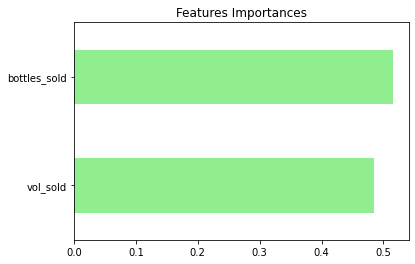

In [70]:
fi = cv_xgb.best_estimator_.named_steps["xgbregressor"].feature_importances_

# Create a pd.Series of features importances
importances = pd.Series(data = fi,
                        index = X_train.columns)

# Sort importances
importances_sorted = importances.sort_values()

# Draw a horizontal barplot of importances_sorted
importances_sorted.plot(kind='barh', color='lightgreen')
plt.title('Features Importances')
plt.show()

# Interpretation

## All features aside from the three in the above visualization could not justify their existence in the dataset; they were not worth the cost of another dimension. Dropping the weakest of the three crossed the line, however, and the model accuracy dropped significantly.
## The most important features do not necessarily cause the target variable (sales crammed in boxcox, in this case) to increase or decrease directly. Still, an expert in the business domain should consider the three, and their significant, positive correlation with sales (as shown below). One starting point to think causually is to suspect that the bottle_cost has a somewhat wide range when it comes to sales, thereby prompting store owners to drop prices more (perhaps in the form of sales).

#### Let's reload the DataFrame becasue it has had many columns dropped.

In [71]:
pkl_f = '.../iowa_liquor_clean7.pkl'
df = pd.read_pickle(pkl_f)

Correlation between fitted sales and bottles_sold: 0.84


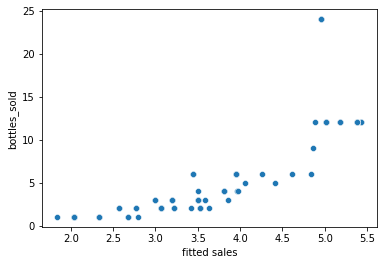

In [72]:
sns.scatterplot(x='fd', y='bottles_sold', data=df)
plt.xlabel('fitted sales')
print(f'Correlation between fitted sales and bottles_sold: {round(corr["bottles_sold"].loc["fd"],2)}')

Correlation between fitted sales and vol_sold: 0.91


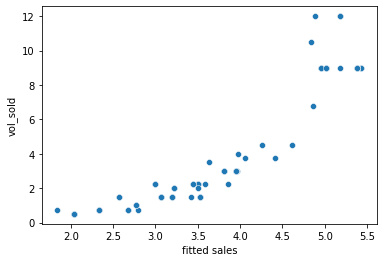

In [73]:
sns.scatterplot(x='fd', y='vol_sold', data=df)
plt.xlabel('fitted sales')
print(f'Correlation between fitted sales and vol_sold: {round(corr["vol_sold"].loc["fd"],2)}')

Correlation between fitted sales and bottle_cost: 0.42


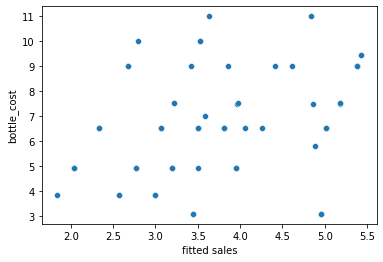

In [74]:
sns.scatterplot(x='fd', y='bottle_cost', data=df)
plt.xlabel('fitted sales')
print(f'Correlation between fitted sales and bottle_cost: {round(corr["bottle_cost"].loc["fd"],2)}')